In [50]:
import queue
import numpy as np
from typing import List, Tuple
import math
import datetime
import pandas as pd
import itertools
from random_gen import RandomNumberGenerator2
import time
from multiprocessing import Pool, cpu_count
import random
import matplotlib.pyplot as plt
from tabulate import tabulate


seed = 42
np.random.seed(seed)
random.seed(seed)



In [51]:
class AlgorithmSA:
    def __init__(self, 
                 iterations:int,
                 factors:Tuple,
                 alpha = 0.995
                 ):
        self.iterations = iterations
        self.factors = factors
        self.alpha = alpha
        
        
    def eval_end_times(self, p) -> List:
        C = []
        length = p[0].shape[0]
        for i in range(length):
            if i == 0:
                C.append(p[0][i] + p[1][i] + p[2][i])
            else:
                tmp = C[i-1] + p[0][i] + p[1][i] + p[2][i]
                C.append(tmp)
        return C
        
        
    def eval_criterion(self, p, d) -> Tuple:
        kry_3 = None
        kry_4 = 0
        kry_5 = None
        C = self.eval_end_times(p)
        length = p[0].shape[0]
        for i in range(length):
            diff = C[i] - d[i]
            
            if kry_5 is None or kry_5 < diff:
                kry_5 = diff
            
            diff_pos = max(diff, 0)
            if kry_3 is None or kry_3 < diff_pos:
                kry_3 = diff_pos
            kry_4 += diff_pos                
        return [kry_3, kry_4, kry_5]        
        
    def get_initial(self, p, d):
        length = len(p[0])
        new_order = np.random.permutation(length)
        p = [p[0][new_order], p[1][new_order], p[2][new_order]]
        d = d[new_order]
        return p, d
    
    def get_neighbor(self, p, d):
        neighbor = p.copy()
        i, j = random.sample(range(p[0].shape[0]), 2)
        neighbor[0][i], neighbor[0][j] = neighbor[0][j], neighbor[0][i]
        neighbor[1][i], neighbor[1][j] = neighbor[1][j], neighbor[1][i]
        neighbor[2][i], neighbor[2][j] = neighbor[2][j], neighbor[2][i]
        
        neighbor_d = d.copy()
        neighbor_d[i], neighbor_d[j] = neighbor_d[j], neighbor_d[i]
        return neighbor, neighbor_d
                        
    
    def calc_prob(self, it):
        try:
            return math.pow(self.alpha, it)
        except Exception as e:
            return 0.0001
    
    def fitness(self, x) -> float:
        return self.factors[0] * x[0] + self.factors[1] * x[1] + self.factors[2] * x[2]
        
    def run(self, p, d):
        it = 0
        p, d = self.get_initial(p, d)
        x = self.eval_criterion(p, d)
        s = self.fitness(x)

        x_best = x.copy()
        s_best = s
                        
        while it < self.iterations:
            p_neigh, d_neigh = self.get_neighbor(p, d)
            x_prim = self.eval_criterion(p_neigh, d_neigh)
            s_prim = self.fitness(x_prim)

            # print(f"Iteration: {it} | Best fit: {s_best} | Current fit: {s} | New fit: {s_prim}")

            if s_prim < s:
                
                if s_prim < s_best:
                    x_best, s_best = x_prim.copy(), s_prim

                p, d = p_neigh, d_neigh
                x, s = x_prim, s_prim
            elif random.random() < self.calc_prob(it):
                p, d = p_neigh, d_neigh
                x, s = x_prim, s_prim
                
            it += 1

        return x_best, s_best


# PERFORM TESTS

In [52]:
random_gen = RandomNumberGenerator2(seedVaule=seed) # type: ignore

reps = 10
reps_instance = 10
iterations_amount = [100, 200, 400, 800, 1600]
instance_size = 100
factors = (1,0.01,1)

res = []
for i in iterations_amount:
    for r in range(reps):
        p, d = random_gen.generate_input(instance_size)
        for ri in range(reps_instance):
            algorithm = AlgorithmSA(iterations=i, factors=factors)
            x, s = algorithm.run(p, d)
            print(f"I: {i} | R:{r}/{reps} | RI: {ri}/{reps_instance} |>> Best solution: {x}, Fitness: {s}")
            
            res.append([i, r, ri, s, x[0], x[1], x[2]])
            
            df = pd.DataFrame(res, columns=["iterations", "rep", "rep_instance", "fitness", "kry_3", "kry_4", "kry_5"])
            df.to_csv("./res/res_zad2.csv", index=False)

I: 100 | R:0/10 |>> Best solution: [np.int64(9847), np.int64(302169), np.int64(9847)], Fitness: 22715.690000000002
I: 100 | R:0/10 |>> Best solution: [np.int64(9197), np.int64(289832), np.int64(9197)], Fitness: 21292.32
I: 100 | R:0/10 |>> Best solution: [np.int64(9900), np.int64(297768), np.int64(9900)], Fitness: 22777.68
I: 100 | R:0/10 |>> Best solution: [np.int64(9614), np.int64(296139), np.int64(9614)], Fitness: 22189.39
I: 100 | R:0/10 |>> Best solution: [np.int64(9703), np.int64(299183), np.int64(9703)], Fitness: 22397.83
I: 100 | R:0/10 |>> Best solution: [np.int64(10705), np.int64(274379), np.int64(10705)], Fitness: 24153.79
I: 100 | R:0/10 |>> Best solution: [np.int64(10494), np.int64(304393), np.int64(10494)], Fitness: 24031.93
I: 100 | R:0/10 |>> Best solution: [np.int64(10063), np.int64(295577), np.int64(10063)], Fitness: 23081.77
I: 100 | R:0/10 |>> Best solution: [np.int64(10089), np.int64(289658), np.int64(10089)], Fitness: 23074.58
I: 100 | R:0/10 |>> Best solution: [n

# PLOTS

+----+--------------+----------------+---------------+--------------+-------------+--------------+-------------+--------------+-------------+
|    |   iterations |   fitness_mean |   fitness_std |   kry_3_mean |   kry_3_std |   kry_4_mean |   kry_4_std |   kry_5_mean |   kry_5_std |
|----+--------------+----------------+---------------+--------------+-------------+--------------+-------------+--------------+-------------|
|  0 |          100 |        22727   |       1470.82 |      9893.55 |     666.92  |       293989 |     21810.1 |      9893.55 |     666.92  |
|  1 |          200 |        22289.4 |       1458.68 |      9686.26 |     669.295 |       291693 |     19128.7 |      9686.26 |     669.295 |
|  2 |          400 |        21419.6 |       1151.18 |      9310.43 |     538.653 |       279876 |     14561.8 |      9310.43 |     538.653 |
|  3 |          800 |        20370.2 |       1004.5  |      8818.11 |     462.913 |       273402 |     15745.9 |      8818.11 |     462.913 |
|  4 |

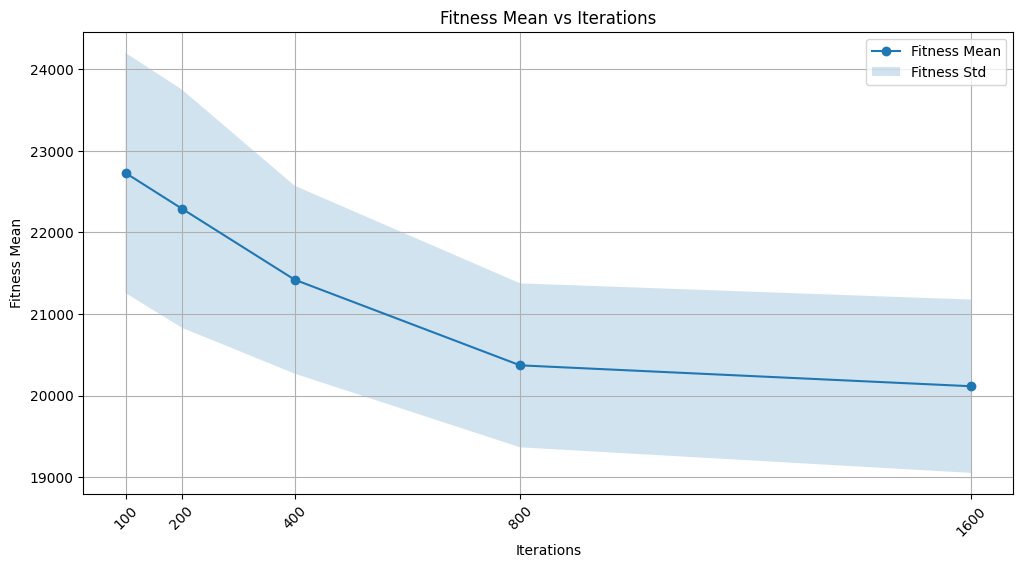

In [53]:
df = pd.read_csv("./res/res_zad2.csv")
df_grouped = df.groupby("iterations").agg(
    fitness_mean = ("fitness", "mean"),
    fitness_std = ("fitness", "std"),
    kry_3_mean = ("kry_3", "mean"),
    kry_3_std = ("kry_3", "std"),
    kry_4_mean = ("kry_4", "mean"),
    kry_4_std = ("kry_4", "std"),
    kry_5_mean = ("kry_5", "mean"),
    kry_5_std = ("kry_5", "std")
).reset_index()
print(tabulate(df_grouped, headers='keys', tablefmt='psql'))


X = df_grouped['iterations'].unique()
Y = df_grouped['fitness_mean'].values
plt.figure(figsize=(12, 6))
plt.plot(X, Y, marker='o', label='Fitness Mean')
plt.fill_between(X, 
                 df_grouped['fitness_mean'] - df_grouped['fitness_std'], 
                 df_grouped['fitness_mean'] + df_grouped['fitness_std'], 
                 alpha=0.2, label='Fitness Std')
plt.xlabel('Iterations')
plt.ylabel('Fitness Mean')
plt.xticks(X)
plt.xticks(rotation=45)
plt.title('Fitness Mean vs Iterations')
plt.legend()
plt.grid()
plt.show()